In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import numpy as np
import re
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd

df = pd.read_excel("/content/drive/MyDrive/full_data.xlsx adlı dosyanın kopyası")

df.drop_duplicates(inplace=True)


In [ ]:
df.head(5)

,Date,Is_evening?,Soup,Main Dish,Side Dish,Extra Dish,Day of Week,Is_holiday?,Ramadan,Semester,Is_final_time?,Fix_Value
0,2023-01-01,0,KARNABAHAR ÇORBA,İZMİR KÖFTE,BULGUR PİLAVI,YOĞURT,Sunday,1,0,Fall,1,243
1,2023-01-01,1,KÖYLÜ ÇORBA,KIYMALI ISPANAK (YOĞURT),SU BÖREĞİ,ELMA,Sunday,1,0,Fall,1,257
2,2023-01-02,0,MISIR ÇORBA,SİCİLYA USULÜ TAVUK (PÜRE),AKDENİZ SALATA,SÜTLAÇ,Monday,0,0,Fall,1,818
3,2023-01-02,1,TARHANA ÇORBA,TAS KEBABI,ŞEH. PİRİNÇ PİLAVI,BAHÇE SALATA,Monday,0,0,Fall,1,773
4,2023-01-03,1,MERCİMEK ÇORBA,KÖRİ SOSLU KÖFTE,KAŞARLI ERİŞTE,ÇİKOLATALI İRMİK TATLISI,Tuesday,0,0,Fall,1,869


In [ ]:
def clean_main_dish(name):
    # Remove parentheses and the text inside
    name = re.sub(r'\s*\(.*?\)', '', name)
    # Remove leading/trailing spaces and double spaces
    name = name.strip()
    name = re.sub(' +', ' ', name)
    return name

# Apply to your column
df["Main Dish"] = df["Main Dish"].apply(clean_main_dish)
df["Side Dish"] = df["Side Dish"].apply(clean_main_dish)
df["Extra Dish"] = df["Extra Dish"].apply(clean_main_dish)


def merge_dish_columns(df, side_dish_col, extra_dish_col, item_list):
    """
    Side Dish ve Extra Dish gibi iki kolondaki ürünleri tekil binary feature'lara dönüştürür.

    Args:
    - df: pandas DataFrame
    - side_dish_col: Side Dish kolonunun ismi (string)
    - extra_dish_col: Extra Dish kolonunun ismi (string)
    - item_list: ürün isimlerinin listesi (örnek: ["Ayran", "Tatlı", "Salata"])

    Returns:
    - Yeni DataFrame (orijinal df'ye eklenmiş şekilde)
    """
    for item in item_list:
        df[item] = ((df[side_dish_col] == item) | (df[extra_dish_col] == item)).astype(int)

    return df

urunler = pd.unique(df[['Side Dish', 'Extra Dish']].values.ravel())
df = merge_dish_columns(df, side_dish_col='Side Dish', extra_dish_col='Extra Dish', item_list=urunler)
df = df.drop(columns=['Side Dish', 'Extra Dish'])

<ipython-input-39-5e97e538af72>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[item] = ((df[side_dish_col] == item) | (df[extra_dish_col] == item)).astype(int)
<ipython-input-39-5e97e538af72>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[item] = ((df[side_dish_col] == item) | (df[extra_dish_col] == item)).astype(int)
<ipython-input-39-5e97e538af72>:29: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining al

In [ ]:
df.head(5)

,Date,Is_evening?,Soup,Main Dish,Day of Week,Is_holiday?,Ramadan,Semester,Is_final_time?,Fix_Value,...,ZY. KEREVİZ,KARDÜŞÜ,PAT. GÜL BÖREĞİ,KARAGÖZ TATLISI,SOSLU SPAGETTİ,NOHUTLU PİRİNÇ PİLAVI,MUH. İRMİK HELVASI,Z.YAĞLI MANTAR,ZEYTİNYAĞLI BROKOLİ,ZEYTİNYAĞLI KABAK
0,2023-01-01,0,KARNABAHAR ÇORBA,İZMİR KÖFTE,Sunday,1,0,Fall,1,243,...,0,0,0,0,0,0,0,0,0,0
1,2023-01-01,1,KÖYLÜ ÇORBA,KIYMALI ISPANAK,Sunday,1,0,Fall,1,257,...,0,0,0,0,0,0,0,0,0,0
2,2023-01-02,0,MISIR ÇORBA,SİCİLYA USULÜ TAVUK,Monday,0,0,Fall,1,818,...,0,0,0,0,0,0,0,0,0,0
3,2023-01-02,1,TARHANA ÇORBA,TAS KEBABI,Monday,0,0,Fall,1,773,...,0,0,0,0,0,0,0,0,0,0
4,2023-01-03,1,MERCİMEK ÇORBA,KÖRİ SOSLU KÖFTE,Tuesday,0,0,Fall,1,869,...,0,0,0,0,0,0,0,0,0,0


<Axes: title={'center': 'Meal Attendance Over Time'}, xlabel='Date'>

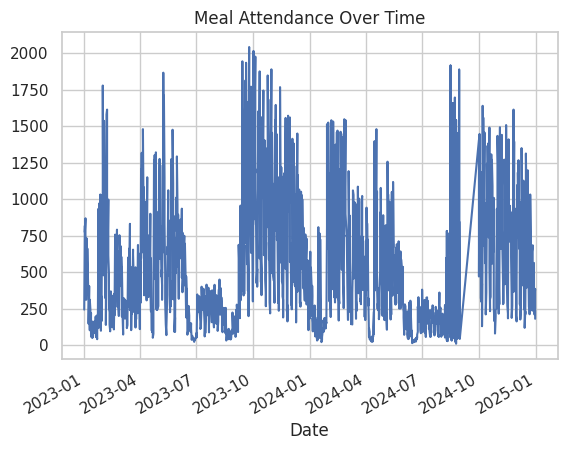

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date')['Fix_Value'].plot(title="Meal Attendance Over Time")


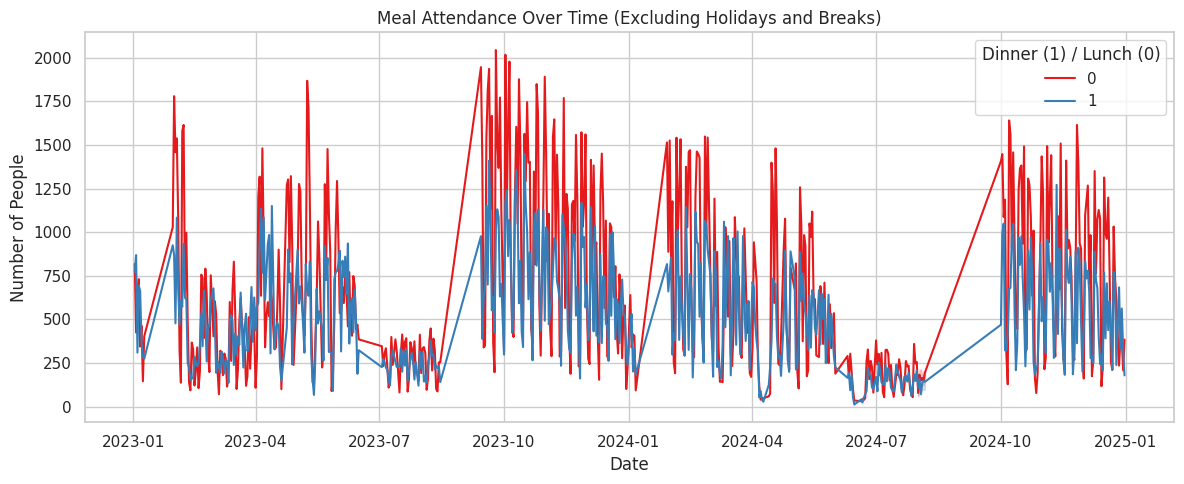

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Define list of semester values that represent long holidays
excluded_semesters = ['Summer Holiday', 'Winter Holiday']

# Filter out holidays and long breaks
df_filtered = df[
    (df['Is_holiday?'] == 0) &
    (~df['Semester'].isin(excluded_semesters))
]

# Plot attendance over time (filtered)
plt.figure(figsize=(12, 5))
sns.lineplot(data=df_filtered, x='Date', y='Fix_Value', hue='Is_evening?', palette='Set1')
plt.title("Meal Attendance Over Time (Excluding Holidays and Breaks)")
plt.ylabel("Number of People")
plt.xlabel("Date")
plt.legend(title="Dinner (1) / Lunch (0)")
plt.tight_layout()
plt.show()


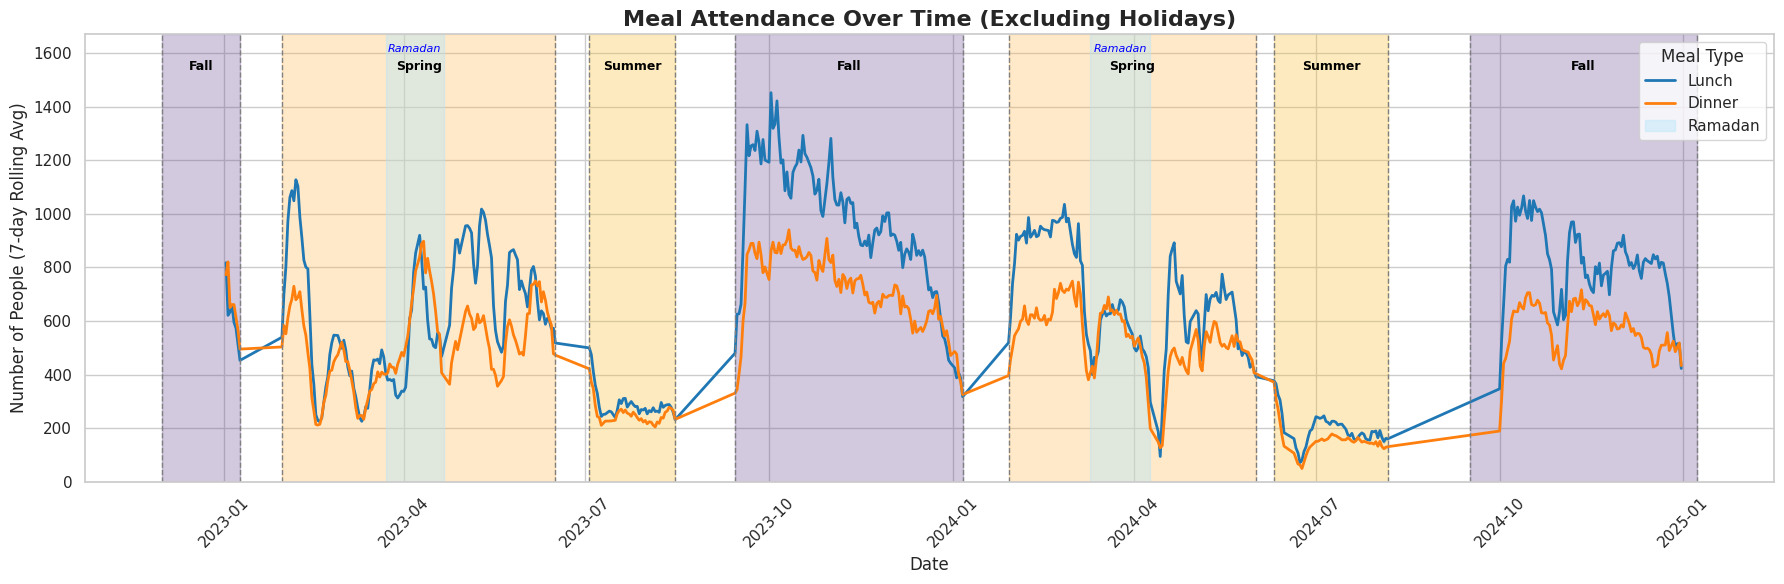

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Filter out holidays and semester breaks
df_filtered = df[(df['Is_holiday?'] == 0) &
                 (~df['Semester'].str.lower().str.contains("holiday"))].copy()
df_filtered = df_filtered.sort_values('Date')

# Add 7-day rolling average
df_filtered['Fix_Value_Smooth'] = df_filtered.groupby('Is_evening?')['Fix_Value'].transform(lambda x: x.rolling(7, min_periods=1).mean())

# Meal labels and colors
palette = {0: "#1f77b4", 1: "#ff7f0e"}  # Teal for Lunch, Bright Orange for Dinner
meal_labels = {0: "Lunch", 1: "Dinner"}

# Define semesters manually from provided academic calendar
semester_boundaries = [
    ("Fall 2022", "2022-12-01", "2023-01-09"),
    ("Spring 2023", "2023-01-30", "2023-06-16"),
    ("Summer 2023", "2023-07-03", "2023-08-15"),
    ("Fall 2023", "2023-09-14", "2024-01-06"),
    ("Spring 2024", "2024-01-29", "2024-06-01"),
    ("Summer 2024", "2024-06-10", "2024-08-06"),
    ("Fall 2024", "2024-09-16", "2025-01-08")
]

semester_colors = {
    "Fall": "#6a4c93",    # Purple for Fall
    "Spring": "#ffb74d",  # Orange for Spring
    "Summer": "#fbc02d",  # Yellow for Summer
}

# Ramadan periods (approximate Gregorian dates)
ramadan_periods = [
    ("Ramadan 2023", "2023-03-23", "2023-04-21"),
    ("Ramadan 2024", "2024-03-10", "2024-04-09")
]

# Start plotting
plt.figure(figsize=(18, 6))
sns.set(style="whitegrid")

# Plot lunch and dinner
for val in [0, 1]:
    subset = df_filtered[df_filtered['Is_evening?'] == val]
    sns.lineplot(data=subset, x='Date', y='Fix_Value_Smooth', label=meal_labels[val],
                 color=palette[val], linewidth=2)

# Add background shading for each semester
for label, start, end in semester_boundaries:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    semester_name = label.split()[0]
    color = semester_colors.get(semester_name, "#FFFFFF")

    plt.axvspan(start_date, end_date, color=color, alpha=0.3)
    plt.axvline(start_date, color='grey', linestyle='--', linewidth=1)
    plt.axvline(end_date, color='grey', linestyle='--', linewidth=1)

    mid_point = start_date + (end_date - start_date) / 2
    plt.text(mid_point, df_filtered['Fix_Value_Smooth'].max() * 1.05,
             semester_name, ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

# Add Ramadan shading
for label, start, end in ramadan_periods:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)

    plt.axvspan(start_date, end_date, color="#b3e5fc", alpha=0.4)

    mid_point = start_date + (end_date - start_date) / 2
    plt.text(mid_point, df_filtered['Fix_Value_Smooth'].max() * 1.10,
             "Ramadan", ha='center', va='bottom', fontsize=8, fontstyle='italic', color='blue')

# Add custom patch for Ramadan to the legend
ramadan_patch = mpatches.Patch(color="#b3e5fc", label='Ramadan', alpha=0.4)
plt.legend(title="Meal Type", handles=plt.gca().get_legend_handles_labels()[0] + [ramadan_patch])

# Final formatting
plt.title("Meal Attendance Over Time (Excluding Holidays)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of People (7-day Rolling Avg)", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, df_filtered['Fix_Value_Smooth'].max() * 1.15)
plt.tight_layout()
plt.show()


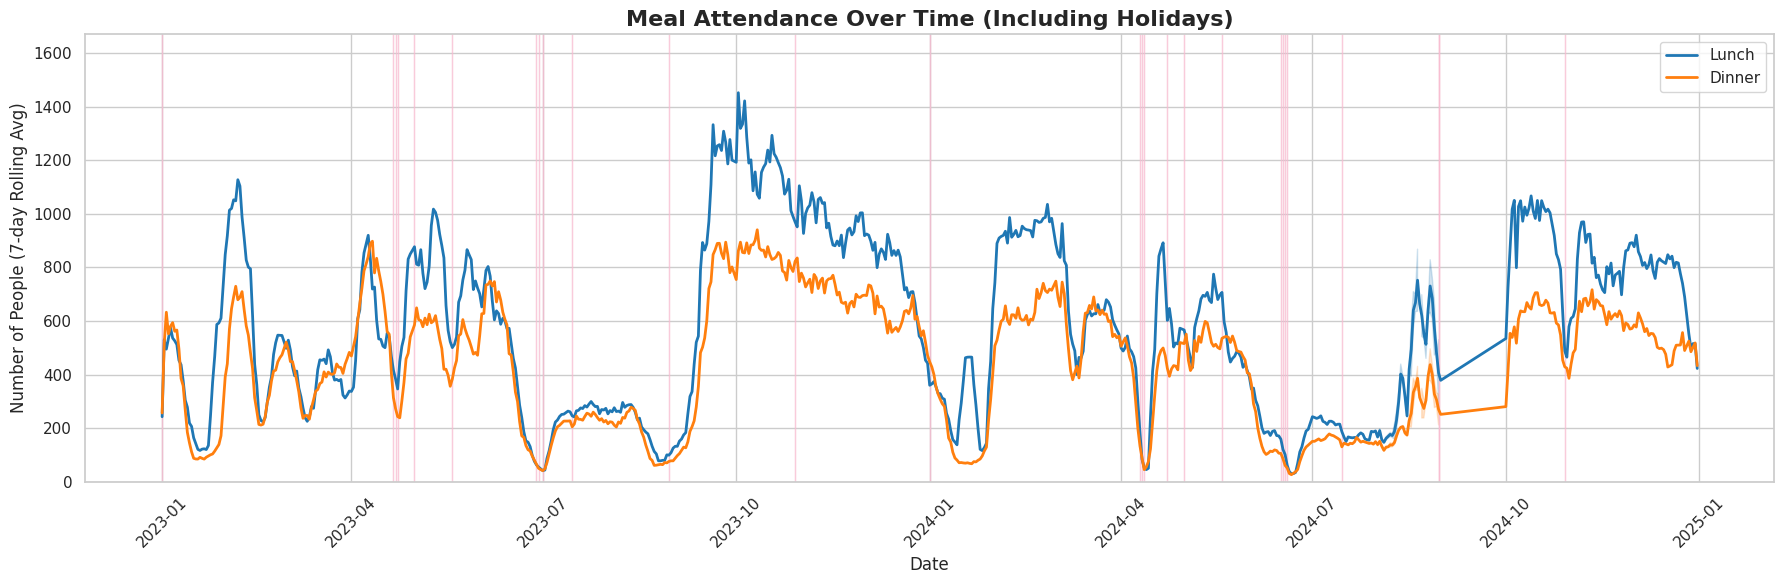

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values('Date')

# Add 7-day rolling average
df['Fix_Value_Smooth'] = df.groupby('Is_evening?')['Fix_Value'].transform(lambda x: x.rolling(7, min_periods=1).mean())

# Meal labels and colors
palette = {0: "#1f77b4", 1: "#ff7f0e"}  # Teal for Lunch, Bright Orange for Dinner
meal_labels = {0: "Lunch", 1: "Dinner"}

# Start plotting
plt.figure(figsize=(18, 6))
sns.set(style="whitegrid")

# Plot lunch and dinner
for val in [0, 1]:
    subset = df[df['Is_evening?'] == val]
    sns.lineplot(data=subset, x='Date', y='Fix_Value_Smooth', label=meal_labels[val],
                 color=palette[val], linewidth=2)

# Add shading for holidays
holiday_periods = df[df['Is_holiday?'] == 1]

for _, holiday in holiday_periods.iterrows():
    start_date = holiday['Date']
    end_date = start_date  # Assuming holiday lasts for one day

    plt.axvspan(start_date, end_date, color="#f8bbd0", alpha=0.5)  # Light pink for holidays
    # Removed plt.text() to avoid labeling "Holiday" on the plot


# Final formatting
plt.title("Meal Attendance Over Time (Including Holidays)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of People (7-day Rolling Avg)", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, df['Fix_Value_Smooth'].max() * 1.15)
plt.tight_layout()
plt.show()


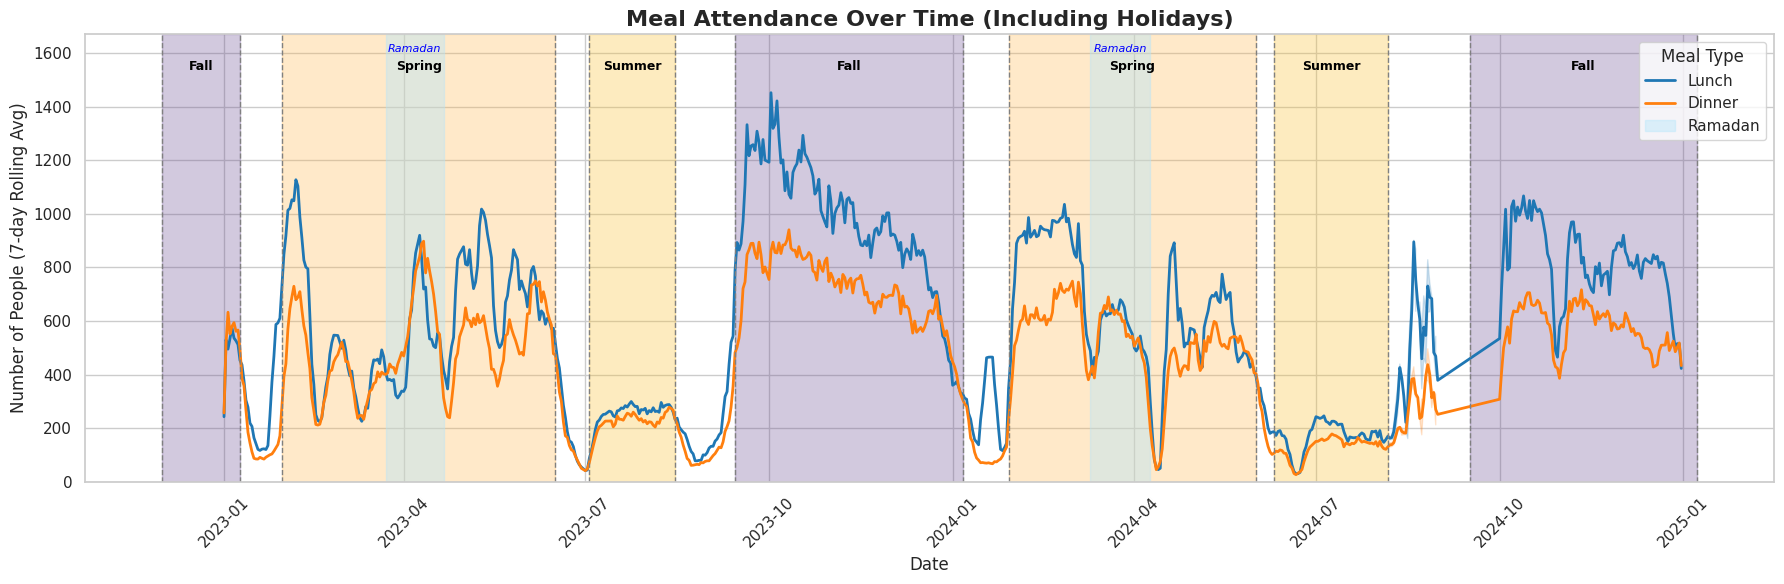

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# No filtering — include holidays and semester breaks
df_full = df.sort_values('Date').copy()

# Add 7-day rolling average
df_full['Fix_Value_Smooth'] = df_full.groupby('Is_evening?')['Fix_Value'].transform(lambda x: x.rolling(7, min_periods=1).mean())

# Meal labels and colors
palette = {0: "#1f77b4", 1: "#ff7f0e"}  # Teal for Lunch, Bright Orange for Dinner
meal_labels = {0: "Lunch", 1: "Dinner"}

# Define semesters manually
semester_boundaries = [
    ("Fall 2022", "2022-12-01", "2023-01-09"),
    ("Spring 2023", "2023-01-30", "2023-06-16"),
    ("Summer 2023", "2023-07-03", "2023-08-15"),
    ("Fall 2023", "2023-09-14", "2024-01-06"),
    ("Spring 2024", "2024-01-29", "2024-06-01"),
    ("Summer 2024", "2024-06-10", "2024-08-06"),
    ("Fall 2024", "2024-09-16", "2025-01-08")
]

semester_colors = {
    "Fall": "#6a4c93",    # Purple for Fall
    "Spring": "#ffb74d",  # Orange for Spring
    "Summer": "#fbc02d",  # Yellow for Summer
}

# Ramadan periods (approximate Gregorian dates)
ramadan_periods = [
    ("Ramadan 2023", "2023-03-23", "2023-04-21"),
    ("Ramadan 2024", "2024-03-10", "2024-04-09")
]

# Start plotting
plt.figure(figsize=(18, 6))
sns.set(style="whitegrid")

# Plot lunch and dinner
for val in [0, 1]:
    subset = df_full[df_full['Is_evening?'] == val]
    sns.lineplot(data=subset, x='Date', y='Fix_Value_Smooth', label=meal_labels[val],
                 color=palette[val], linewidth=2)

# Add background shading for each semester
for label, start, end in semester_boundaries:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    semester_name = label.split()[0]
    color = semester_colors.get(semester_name, "#FFFFFF")

    plt.axvspan(start_date, end_date, color=color, alpha=0.3)
    plt.axvline(start_date, color='grey', linestyle='--', linewidth=1)
    plt.axvline(end_date, color='grey', linestyle='--', linewidth=1)

    mid_point = start_date + (end_date - start_date) / 2
    plt.text(mid_point, df_full['Fix_Value_Smooth'].max() * 1.05,
             semester_name, ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

# Add Ramadan shading
for label, start, end in ramadan_periods:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)

    plt.axvspan(start_date, end_date, color="#b3e5fc", alpha=0.4)

    mid_point = start_date + (end_date - start_date) / 2
    plt.text(mid_point, df_full['Fix_Value_Smooth'].max() * 1.10,
             "Ramadan", ha='center', va='bottom', fontsize=8, fontstyle='italic', color='blue')

# Add custom patch for Ramadan to the legend
ramadan_patch = mpatches.Patch(color="#b3e5fc", label='Ramadan', alpha=0.4)
plt.legend(title="Meal Type", handles=plt.gca().get_legend_handles_labels()[0] + [ramadan_patch])

# Final formatting
plt.title("Meal Attendance Over Time (Including Holidays)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of People (7-day Rolling Avg)", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, df_full['Fix_Value_Smooth'].max() * 1.15)
plt.tight_layout()
plt.show()


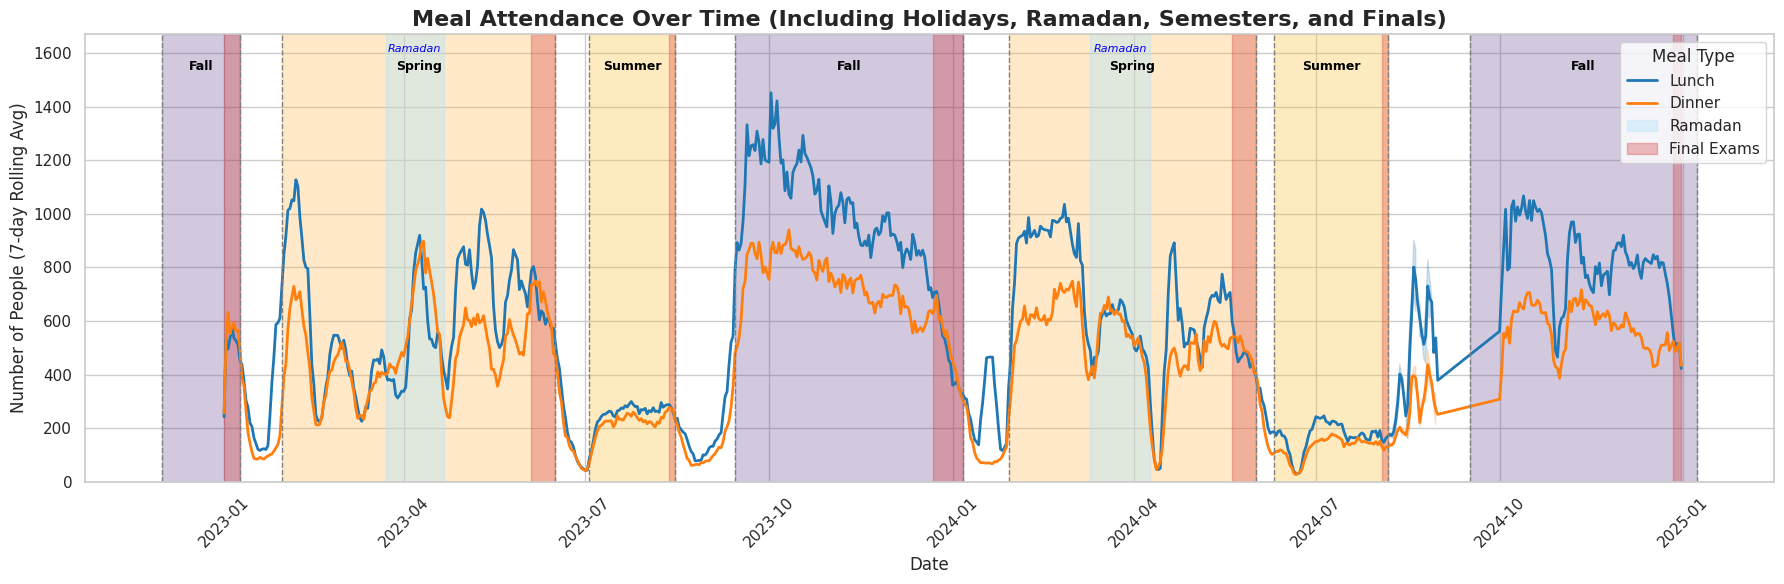

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patches as mpatches

# Convert Date column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# No filtering — include holidays and semester breaks
df_full = df.sort_values('Date').copy()

# Add 7-day rolling average
df_full['Fix_Value_Smooth'] = df_full.groupby('Is_evening?')['Fix_Value'].transform(lambda x: x.rolling(7, min_periods=1).mean())

# Meal labels and colors
palette = {0: "#1f77b4", 1: "#ff7f0e"}  # Teal for Lunch, Bright Orange for Dinner
meal_labels = {0: "Lunch", 1: "Dinner"}

# Define semesters manually
semester_boundaries = [
    ("Fall 2022", "2022-12-01", "2023-01-09"),
    ("Spring 2023", "2023-01-30", "2023-06-16"),
    ("Summer 2023", "2023-07-03", "2023-08-15"),
    ("Fall 2023", "2023-09-14", "2024-01-06"),
    ("Spring 2024", "2024-01-29", "2024-06-01"),
    ("Summer 2024", "2024-06-10", "2024-08-06"),
    ("Fall 2024", "2024-09-16", "2025-01-08")
]

semester_colors = {
    "Fall": "#6a4c93",    # Purple for Fall
    "Spring": "#ffb74d",  # Orange for Spring
    "Summer": "#fbc02d",  # Yellow for Summer
}

# Ramadan periods (approximate Gregorian dates)
ramadan_periods = [
    ("Ramadan 2023", "2023-03-23", "2023-04-21"),
    ("Ramadan 2024", "2024-03-10", "2024-04-09")
]

# Start plotting
plt.figure(figsize=(18, 6))
sns.set(style="whitegrid")

# Plot lunch and dinner
for val in [0, 1]:
    subset = df_full[df_full['Is_evening?'] == val]
    sns.lineplot(data=subset, x='Date', y='Fix_Value_Smooth', label=meal_labels[val],
                 color=palette[val], linewidth=2)

# Add background shading for each semester
for label, start, end in semester_boundaries:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)
    semester_name = label.split()[0]
    color = semester_colors.get(semester_name, "#FFFFFF")

    plt.axvspan(start_date, end_date, color=color, alpha=0.3)
    plt.axvline(start_date, color='grey', linestyle='--', linewidth=1)
    plt.axvline(end_date, color='grey', linestyle='--', linewidth=1)

    mid_point = start_date + (end_date - start_date) / 2
    plt.text(mid_point, df_full['Fix_Value_Smooth'].max() * 1.05,
             semester_name, ha='center', va='bottom', fontsize=9, fontweight='bold', color='black')

# Add Ramadan shading
for label, start, end in ramadan_periods:
    start_date = pd.to_datetime(start)
    end_date = pd.to_datetime(end)

    plt.axvspan(start_date, end_date, color="#b3e5fc", alpha=0.4)

    mid_point = start_date + (end_date - start_date) / 2
    plt.text(mid_point, df_full['Fix_Value_Smooth'].max() * 1.10,
             "Ramadan", ha='center', va='bottom', fontsize=8, fontstyle='italic', color='blue')

# Add Final Time Shading based on Is_final_time
# Add Final Time Shading based on Is_final_time
is_final = df_full['Is_final_time?'].reset_index(drop=True)
dates = df_full['Date'].reset_index(drop=True)
start_date = None

for i in range(len(is_final)):
    if is_final[i] == 1 and (i == 0 or is_final[i - 1] == 0):  # Start of finals
        start_date = dates[i]
    elif is_final[i] == 0 and i > 0 and is_final[i - 1] == 1 and start_date is not None:  # End of finals
        end_date = dates[i - 1]
        plt.axvspan(start_date, end_date, color="#d32f2f", alpha=0.3)
        mid_point = start_date + (end_date - start_date) / 2
        plt.text(mid_point, df_full['Fix_Value_Smooth'].max() * 1.15,
                 "Finals", ha='center', va='bottom', fontsize=9, fontweight='bold', color='white')

# Handle case where the last date is still during finals
if is_final.iloc[-1] == 1 and start_date is not None:
    end_date = dates.iloc[-1]
    plt.axvspan(start_date, end_date, color="#d32f2f", alpha=0.3)
    mid_point = start_date + (end_date - start_date) / 2
    plt.text(mid_point, df_full['Fix_Value_Smooth'].max() * 1.15,
             "Finals", ha='center', va='bottom', fontsize=9, fontweight='bold', color='white')

# Add custom patch for Ramadan and Finals to the legend
ramadan_patch = mpatches.Patch(color="#b3e5fc", label='Ramadan', alpha=0.4)
final_patch = mpatches.Patch(color="#d32f2f", label='Final Exams', alpha=0.3)
plt.legend(title="Meal Type", handles=plt.gca().get_legend_handles_labels()[0] + [ramadan_patch, final_patch])

# Final formatting
plt.title("Meal Attendance Over Time (Including Holidays, Ramadan, Semesters, and Finals)", fontsize=16, fontweight='bold')
plt.xlabel("Date", fontsize=12)
plt.ylabel("Number of People (7-day Rolling Avg)", fontsize=12)
plt.xticks(rotation=45)
plt.ylim(0, df_full['Fix_Value_Smooth'].max() * 1.15)
plt.tight_layout()
plt.show()


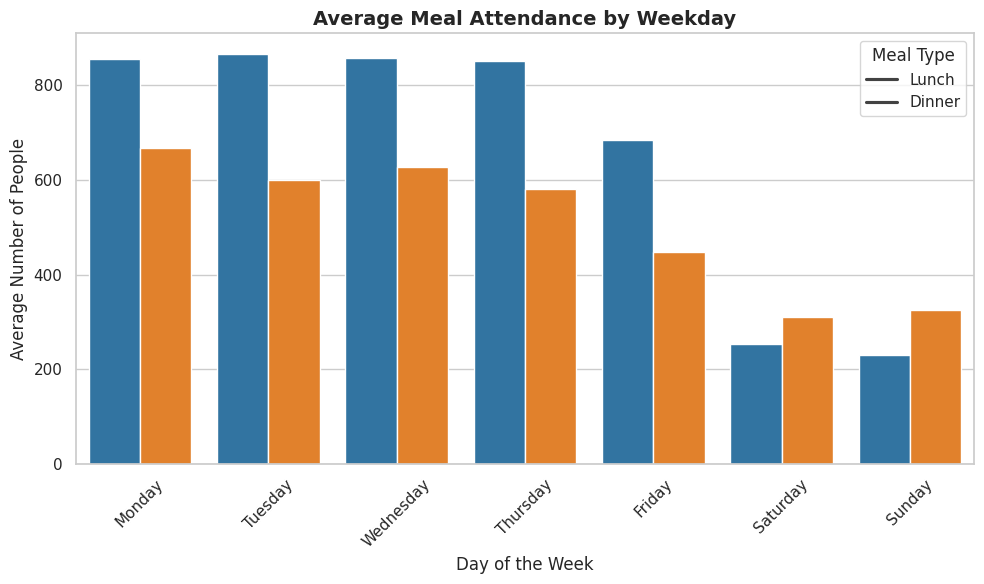

In [ ]:
import calendar

# Add weekday column
df_filtered['Weekday'] = df_filtered['Date'].dt.weekday  # 0 = Monday, 6 = Sunday
df_filtered['Weekday_Name'] = df_filtered['Weekday'].apply(lambda x: calendar.day_name[x])

# Group by Weekday and Meal
weekday_avg = df_filtered.groupby(['Weekday_Name', 'Is_evening?'])['Fix_Value'].mean().reset_index()

# Order the days
weekday_order = list(calendar.day_name)

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=weekday_avg, x='Weekday_Name', y='Fix_Value', hue='Is_evening?',
            hue_order=[0, 1], palette=palette, order=weekday_order)

# Labels
plt.title("Average Meal Attendance by Weekday", fontsize=14, fontweight='bold')
plt.xlabel("Day of the Week", fontsize=12)
plt.ylabel("Average Number of People", fontsize=12)
plt.legend(title="Meal Type", labels=["Lunch", "Dinner"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
